In [1]:
# Importing the libraries

In [2]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
path = 'D:/data folder/1661-0.txt'
with open(path, encoding='latin-1') as f:
    text = f.read().lower()


In [4]:
tokenizer=RegexpTokenizer(r'\w+')
words=tokenizer.tokenize(text)
print(words)

['ï', 'project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'www', 'gutenberg', 'net', 'title', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'author', 'arthur', 'conan', 'doyle', 'release', 'date', 'november', '29', '2002', 'ebook', '1661', 'last', 'updated', 'may', '20', '2019', 'language', 'english', 'character', 'set', 'encoding', 'utf', '8', 'start', 'of', 'this', 'project', 'gutenberg', 'ebook', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'produced', 'by', 'an', 'anonymous', 'project', 'gutenberg', 'volunteer', 'and', 'jose', 'menendez', 'cover', 'the', 'adventu

In [5]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [54]:
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
indices_char = {i: c for c, i in unique_word_index.items()}  # Add this line

In [ ]:
# feature Engineering

In [72]:
WORD_LENGTH = 3
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['ï', 'project', 'gutenberg']
s


In [80]:
X = np.zeros((len(prev_words), WORD_LENGTH), dtype=int)
Y = np.zeros(len(next_words), dtype=int)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j]=  unique_word_index.get(each_word,0)
    Y[i]=unique_word_index.get(next_words[i],0)

In [81]:
print(X[0][0])

8478


# Building the Recurrent Neural Networks

In [82]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# Training next word prediction model

In [83]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

Epoch 1/2


ValueError: in user code:

    File "D:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "D:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "D:\anaconda\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "D:\anaconda\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\anaconda\lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "lstm_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 3)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 3), dtype=int32)
      • training=True
      • mask=None


In [84]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

D:\anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


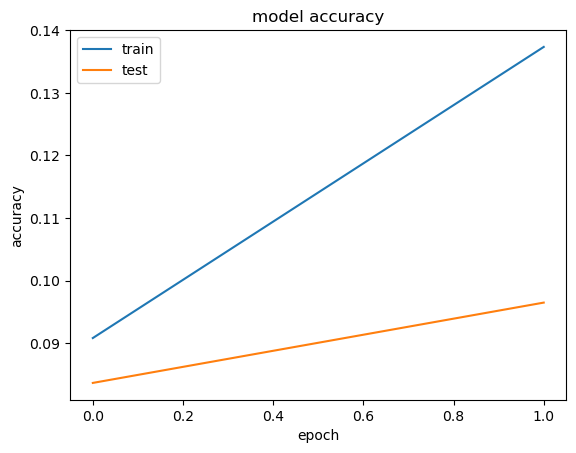

In [85]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

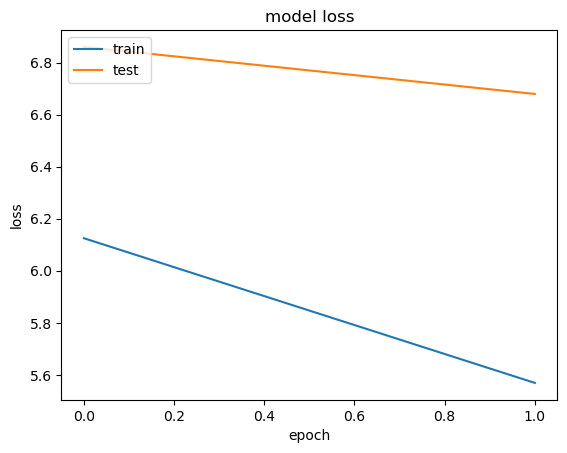

In [86]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [87]:
"""
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())
"""


def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    words = text.split()[-WORD_LENGTH:]  # Keep only last WORD_LENGTH words
    for t, word in enumerate(words):
        if word in unique_word_index:  # Ensure the word exists in unique_word_index
            x[0, t, unique_word_index[word]] = 1
    return x


In [88]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [89]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [90]:
def predict_completion_1(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

# Testing the model

In [91]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completion_1(seq,5))
    print()

it is not a lack of love, but a lack of 


In [ ]:
# sorry but my laptop is bit old to process GBs of data. So it ends here. If you have high end laptop. It'll
# work at your end